In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Uber/images.zip

In [12]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import pandas as pd
import torch.nn.functional as F

In [13]:
image_paths = './data/images/*/*'
image_paths = glob(image_paths)

In [14]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [15]:
np.unique(labels)

array(['flaky', 'point-flaky', 'point-like'], dtype='<U11')

In [16]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 3)))
pred2label = dict(zip(range(0, 3), np.unique(labels)))
n_classes = len(np.unique(labels))

In [17]:
class CornealUlcers(torch.utils.data.Dataset):
    
    def __init__(self, image_paths, labels, transforms=None):
        super(CornealUlcers, self).__init__()
        
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (400, 400))
            
        label = self.labels[idx]
        label = label2pred[label]
        label = torch.tensor(label)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label        

In [32]:
device='cpu'

In [33]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, shuffle=True, stratify=labels)

In [34]:
tr_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#    torchvision.transforms.RandomHorizontalFlip(),
#    torchvision.transforms.RandomRotation(60),
#    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.CenterCrop(380),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(380),
])

In [35]:
train_dataset = CornealUlcers(image_paths=train_image_paths, labels=train_labels, transforms=tr_transforms)
test_dataset = CornealUlcers(image_paths=test_image_paths, labels=test_labels, transforms=val_transforms)

In [36]:
len(train_dataset)

569

In [37]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)

point-like


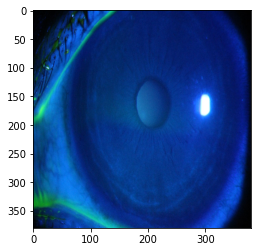

In [38]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[10][0].permute(1, 2, 0))
print(pred2label[train_dataset[10][1].item()])

In [39]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}\n".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [40]:
torchvision.models.efficientnet_b4().classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

In [41]:
class EfficientNet(ClassificationBase):
    
    def __init__(self):
        super().__init__()
        
        self.network = torchvision.models.efficientnet_b4(weights = True)
        num_ftrs = self.network.classifier
        self.network.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(1792, n_classes))
        
    def forward(self, batch):
        batch = batch.to(device)
        return self.network(batch)
        
        
        
model = EfficientNet()     

/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
def fit(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), 1e-5)
    for epoch in range(epochs):
        lrs = []
        loss = 0
        acc = 0
        for batch in tqdm.tqdm(train_loader):
            model.train()
            loss, acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(
            "Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, loss, acc))
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
model = model.to(device)

In [ ]:
evaluate(model, test_dataloader)

In [45]:
import tqdm
model.train()
history = fit(5, model, train_dataloader, test_dataloader)

100%|██████████| 29/29 [00:48<00:00,  1.68s/it]


Epoch [0], loss: 0.8990, acc: 0.7778
Epoch [0], val_loss: 0.1930, val_acc: 0.9500



100%|██████████| 29/29 [00:48<00:00,  1.67s/it]


Epoch [1], loss: 0.2484, acc: 0.8889
Epoch [1], val_loss: 0.1623, val_acc: 0.9625



100%|██████████| 29/29 [00:48<00:00,  1.67s/it]


Epoch [2], loss: 0.0582, acc: 1.0000
Epoch [2], val_loss: 0.1831, val_acc: 0.9500



100%|██████████| 29/29 [00:48<00:00,  1.67s/it]


Epoch [3], loss: 0.0202, acc: 1.0000
Epoch [3], val_loss: 0.1702, val_acc: 0.9562



100%|██████████| 29/29 [00:48<00:00,  1.68s/it]


Epoch [4], loss: 0.5754, acc: 0.6667
Epoch [4], val_loss: 0.1903, val_acc: 0.9500



In [52]:
model.eval()
evaluate(model, test_dataloader)
#model.train()
#10:13:54

{'val_loss': 0.10229068994522095, 'val_acc': 0.9749999642372131}

In [ ]:
torch.save(model.state_dict(), 'EfficientNet-0.97.pth')

In [53]:
losses = []
accs = []
for i in range(len(history)):
  losses.append(history[i]['val_loss'])
  accs.append(history[i]['val_acc'])

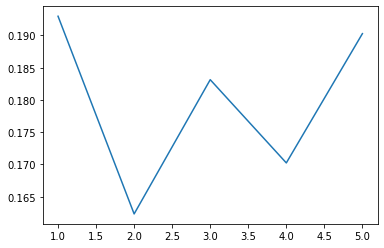

In [54]:
plt.plot(np.linspace(1, 5, 5).astype(int), losses)

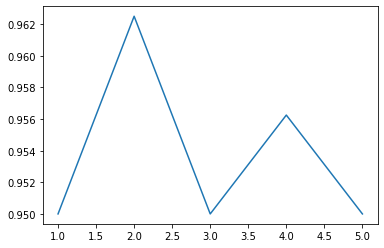

In [55]:
plt.plot(np.linspace(1, 5, 5).astype(int), accs)

In [46]:
model.load_state_dict(torch.load('EfficientNet-0.97.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

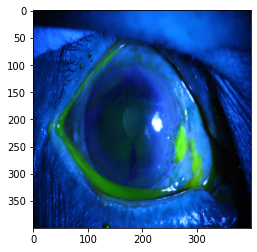

In [54]:
image = cv2.imread('./Data/images/flaky/630.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (400, 400))
plt.imshow(image)

In [55]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((380, 380))
])

image = test_transforms(image)
image = torch.reshape(image, (1, 3, 380, 380))

In [56]:
model.eval()
pred2label[np.argmax(model(image).cpu().detach().numpy())]

'flaky'